# Calculating the delta of a digital option

Consider a **digital option** which pays 1 euro if the stock price at expiry is higher than thestrike and otherwise nothing. 

Since the payoff is not continues we have two options to calculate delta:

- Use the **Likelihood Ratio Method**
- Use the **Pathwise Method** after transforming the payoffs to ensure continuity (Using the CDF of a nromla distribution as a smoothing function)

## Likelihood ratio method

$$ \delta = e^{-rT} 1_{S_{t} > K} \frac{Z}{S_{o}\sigma \sqrt{T}} $$


In [3]:
import numpy as np
from numba import njit
from numba import jit
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
# Parameters
T = 1
K = 99
S0 = 100
r = 0.06
sigma = 0.2

In [21]:
def digital_option(S0, K ,r ,sigma ,T ,n_iter):
    mc_payoffs = []
    for i in range(n_iter):
        # Calculating the Stock price at T
        phi = np.random.standard_normal()
        ST = S0 * np.exp((r - 0.5 * sigma ** 2 ) * T + sigma * np.sqrt(T) * phi)

        # Check if digital option pays off
        if ST-K > 0:
            mc_payoffs.append( 1 * np.exp(-r)) # Present value of 1 euro
        else:
            mc_payoffs.append(0) # or present value of nothing

    # Returns a series of simulated prsent value digital option payoffs
    return mc_payoffs

In [8]:
@njit
def digital_delta_likelihood(S0, K ,r ,sigma ,T ,n_iter):
    deltas = []
    for i in range(n_iter):
        # Calculating the Stock price at T
        phi = np.random.standard_normal()
        ST = S0 * np.exp((r - 0.5 * sigma ** 2 ) * T + sigma * np.sqrt(T) * phi)

        if ST > K: # Option has a value of 1
            deltas.append( np.exp( -r * T) * 1 * ( phi / (S0*sigma*np.sqrt(T))))
        else: # Option has a value of 0
            deltas.append( np.exp( -r * T) * 0 * ( phi / (S0*sigma*np.sqrt(T))))
    return deltas

In [10]:
mean_deltas = []
for i in range(1000):
    deltas = digital_delta_likelihood(S0, K ,r ,sigma ,T ,n_iter=100000)
    mean_deltas.append(np.mean(deltas))

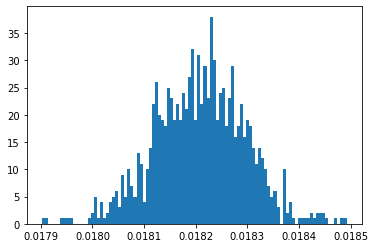

In [12]:
plt.hist(mean_deltas, bins=100)
plt.show()

In [15]:
print(f"Mean delta likelihood: {np.mean(mean_deltas)}")
print(f"Delta variance likelihood: {np.std(mean_deltas)}")

Mean delta likelihood: 0.018208655603515634
Delta variance likelihood: 8.749211727782139e-05


## Bump and Revalue

$$ \delta = \frac{V(S + \epsilon) -  V(S)}{\epsilon} $$

In [25]:
# Parameters
T = 1
K = 99
S0 = stock_price =  100
r = 0.06
sigma = 0.2
e = epsilon = 0.0001
n_iter = 1000

In [26]:
# Set common seed
seed = np.random.seed(69)

In [35]:
@njit
def digital_option_bumped(S0, K ,r ,sigma ,T ,n_iter, epsilon):
    ''' Adjust digital option pricing for a bumped stock price'''
    mc_payoffs = []
    for i in range(n_iter):
        # Calculating the Stock price at T
        phi = np.random.standard_normal()
        ST = (S0+epsilon) * np.exp((r - 0.5 * sigma ** 2 ) * T + sigma * np.sqrt(T) * phi)

        # Check if digital option pays off
        if ST-K > 0:
            mc_payoffs.append( 1 * np.exp(-r)) # Present value of 1 euro
        else:
            mc_payoffs.append(0) # or present value of nothing

    # Returns a series of simulated prsent value digital option payoffs
    return mc_payoffs

# test = digital_option_bumped(S0, K ,r ,sigma ,T ,n_iter, epsilon)

In [28]:
@njit
def euler_digital_valuation(n_iter, epsilon):
    # All the valuations of the digital option (itself a mean of simulated paths)
    all_digital_valuations = []
    for i in range(n_iter):
        np.random.seed(69)

        # Realised payoffs in n_iter simulated paths 
        payoffs = digital_option_bumped(S0, K ,r ,sigma ,T ,n_iter, epsilon)
        all_digital_valuations.append(np.mean(np.array(payoffs))) # If i don't castthe list of results to an array it won't work!!
    
    return all_digital_valuations

In [53]:
@njit
def digital_delta_bumped(n_iter, epsilon,same_seed=True):
    if same_seed:
        bumped_values = euler_digital_valuation(n_iter, epsilon=epsilon)
        unbumped_values = euler_digital_valuation(n_iter, epsilon=0)
    else:
        pass
    delta =  (np.mean(np.array(bumped_values)) - np.mean(np.array(unbumped_values))) / epsilon
    return delta

test = digital_delta_bumped(1000, epsilon=0.01)
test

0.1883529067174372

As epsilon goes to zero the delta goes to zero as well, in order to get a positive value epsilon needs to be set a bit higher. See "Results digital call" in the slides for MCII

In [60]:
mean_deltas = []
for j in tqdm(range(100)):
    deltas = []
    for i in range(200):
        delta = digital_delta_bumped(500, epsilon=0.01)
        deltas.append(delta)
    mean_deltas.append(np.mean(np.array(deltas)))







  0%|          | 0/100 [00:00<?, ?it/s]





  1%|          | 1/100 [00:07<12:05,  7.33s/it]





  2%|▏         | 2/100 [00:14<11:57,  7.32s/it]





  3%|▎         | 3/100 [00:21<11:49,  7.32s/it]





  4%|▍         | 4/100 [00:29<11:43,  7.33s/it]





  5%|▌         | 5/100 [00:36<11:36,  7.33s/it]





  6%|▌         | 6/100 [00:43<11:27,  7.32s/it]





  7%|▋         | 7/100 [00:51<11:19,  7.31s/it]





  8%|▊         | 8/100 [00:58<11:14,  7.33s/it]





  9%|▉         | 9/100 [01:05<11:06,  7.33s/it]





 10%|█         | 10/100 [01:13<11:01,  7.35s/it]





 11%|█         | 11/100 [01:21<11:28,  7.74s/it]





 12%|█▏        | 12/100 [01:29<11:17,  7.70s/it]





 13%|█▎        | 13/100 [01:36<10:59,  7.58s/it]





 14%|█▍        | 14/100 [01:44<10:45,  7.50s/it]





 15%|█▌        | 15/100 [01:51<10:31,  7.43s/it]





 16%|█▌        | 16/100 [01:59<10:31,  7.51s/it]





 17%|█▋        | 17/100 [02:08<11:08,  8.05s/it]





 18%|█▊        | 18/100 [02:16<11:05,  8

In [58]:
print(f"Mean delta likelihood: {np.mean(mean_deltas)}")
print(f"Delta variance likelihood: {np.std(mean_deltas)}")

Mean delta likelihood: 0.3767058134339972
Delta variance likelihood: 0.0


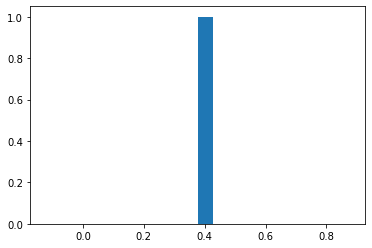

In [59]:
plt.hist(mean_deltas, bins=20)
plt.show()